In [1]:
import os
import numpy as np 
import pandas as pd
from scipy.stats import stats
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('dz4.csv', sep = ';', index_col = False) ;
df['cheks'] = df['cheks'].round(3)
df.info(memory_usage='deep') ;
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4680 entries, 0 to 4679
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   user_id  4680 non-null   int64  
 1   cheks    4680 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 73.3 KB


,user_id,cheks
count,4680.000000,4680.000000
mean,504.374145,1508.605345
std,290.211063,297.485338
min,1.000000,533.478000
25%,255.000000,1298.682250
50%,506.000000,1509.530500
75%,764.000000,1712.789750
max,1000.000000,2471.163000


### 2.1 (2 балла) Проверить, что распределение p-value на А/А-тестах для среднего чека (глобальное среднее) в по-юзерном тесте далеко не идеально в t-критерии, сделать вывод о применимости t-тест.

In [3]:
from statsmodels.stats.weightstats import ttest_ind

In [4]:
avg = (df.groupby('user_id')
                  ['cheks']
                  .mean()
                  .reset_index(name='Avg'))
num_tests = 1000
p_values = []

In [5]:
for i in range(num_tests):
    group1 = np.random.choice(avg['Avg'].values , 500)
    group2 = np.random.choice(avg['Avg'].values, 500)
    p_value = ttest_ind(group1, group2)
    p_values.append(p_value)
    i+=1

Доля ошибок первого рода: 0.19


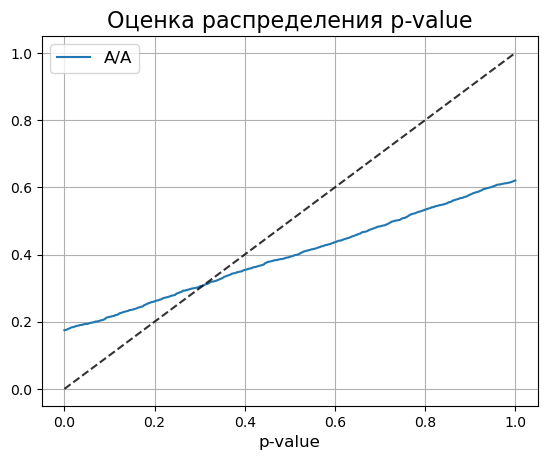

In [19]:
def plot_pvalue_distribution(dict_pvalues):
    X = np.linspace(0, 1, 1000)
    for name, pvalues in dict_pvalues.items():
        Y = [np.mean(pvalues < x) for x in X]
        plt.plot(X, Y, label=name)

    plt.plot([0, 1], [0, 1], '--k', alpha=0.8)
    plt.title('Оценка распределения p-value', size=16)
    plt.xlabel('p-value', size=12)
    plt.legend(fontsize=12)
    plt.grid()
    plt.show()
    
alpha = 0.05

error_rate = np.mean(np.array(p_values) < alpha)
print(f'Доля ошибок первого рода: {error_rate:0.2f}')
plot_pvalue_distribution({'A/A': p_values})

### 2.2 (2 балла) Проверить через распределение p-value на А/А-тестах, работает ли дельта-метод для глобального среднего.

Доля ошибок первого рода: 0.04


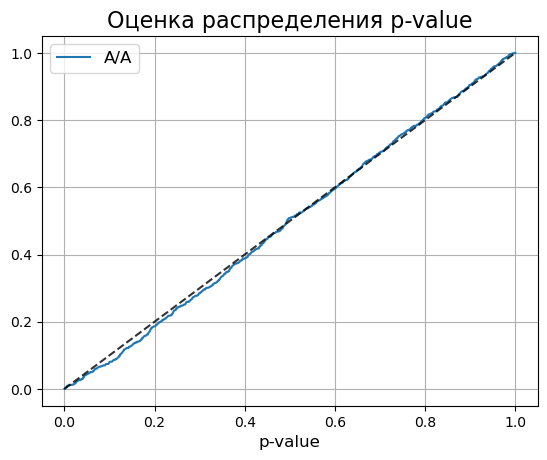

In [28]:
def check_delta_method(a, b):
    """Проверка гипотезы с помощью дельта-метода.

    Возвращает p-value.
    """
    dict_ = {}
    for data, group_name in [(a, 'a',), (b, 'b',)]:
        n_user = 500
        array_x = np.array([np.sum(row) for row in data])
        array_y = np.array([500 for row in data])
        mean_x, mean_y = np.mean(array_x), np.mean(array_y)
        var_x, var_y = np.var(array_x), np.var(array_y)
        cov_xy = np.cov(array_x, array_y)[0, 1]
        # точечная оценка метрики
        pe_metric = np.sum(array_x) / np.sum(array_y)
        # оценка дисперсии метрики
        var_metric = (
            var_x / mean_y ** 2
            - 2 * (mean_x / mean_y ** 3) * cov_xy
            + (mean_x ** 2 / mean_y ** 4) * var_y
        ) / n_user
        dict_[f'pe_metric_{group_name}'] = pe_metric
        dict_[f'var_metric_{group_name}'] = var_metric
    var = dict_['var_metric_a'] + dict_['var_metric_b']
    delta = dict_['pe_metric_b'] - dict_['pe_metric_a']
    t = delta / np.sqrt(var)
    pvalue = (1 - stats.norm.cdf(np.abs(t))) * 2
    return pvalue

num_tests = 1000
p_values = []

for i in range(num_tests):
    group1 = np.random.choice(avg['Avg'].values , 500)
    group2 = np.random.choice(avg['Avg'].values, 500)
    p_value = check_delta_method(group1, group2)
    p_values.append(p_value)
    i+=1
alpha = 0.05

error_rate = np.mean(np.array(p_values) < alpha)
print(f'Доля ошибок первого рода: {error_rate:0.2f}')
plot_pvalue_distribution({'A/A': p_values})

### 2.3 (2 балла) Проверить аналогично прошлым пунктам применимость t-теста для нормализованного (двойного) среднего.

Доля ошибок первого рода: 0.19


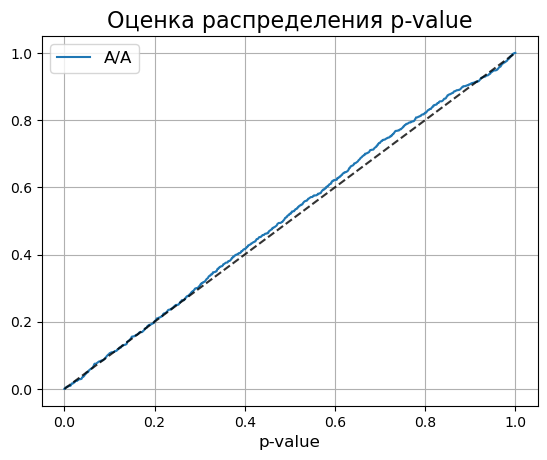

In [20]:
pvalues = []
for _ in range(1000):
    group1 = np.random.choice(avg['Avg'].values , 500)
    group2 = np.random.choice(avg['Avg'].values, 500)
    a_means = [np.mean(x) for x in group1]
    b_means = [np.mean(x) for x in group2]
    pvalue = stats.ttest_ind(a_means, b_means).pvalue
    pvalues.append(pvalue)
alpha = 0.05

error_rate = np.mean(np.array(p_values) < alpha)
print(f'Доля ошибок первого рода: {error_rate:0.2f}')
plot_pvalue_distribution({'A/A': pvalues})

### 2.4 (2 баллаа) Сделать симуляции А/А-тестов таким образом – сгенерить эффект для таргетной группы так, чтобы среднее у него было 0, а дисперсия какая-то ненулевая. Проверить, что нормализованное среднее все еще стабильно в t-тесте.

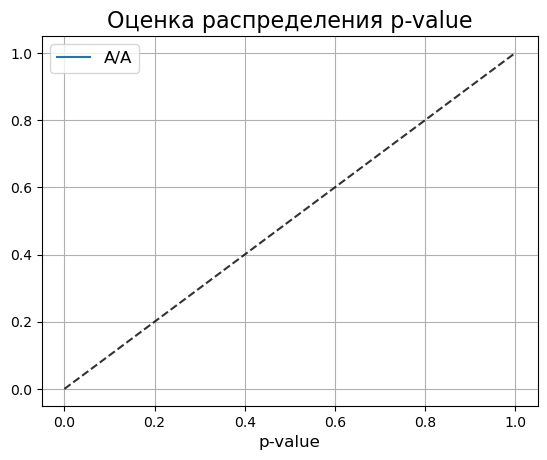

In [41]:
pvalues = []
for i in range(num_tests):
    sample_size = 500
    effect_std = 1 
    # Случайным образом выбираем выборки для каждой группы
    group1 = np.random.choice(avg['Avg'].values, size=sample_size, replace=False)
    group2 = np.random.choice(avg['Avg'].values, size=sample_size, replace=False)
    
    # Генерируем случайный эффект для таргетной группы
    target_effect = np.random.normal(loc=0, scale=effect_std, size=sample_size)
    group2 += target_effect  # Применяем эффект к таргетной группе
    
    # Выполняем t-тест
    p_value = ttest_ind(group1, group2)
    p_values.append(p_value)
    i+=1

plot_pvalue_distribution({'A/A': pvalues})

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (9000,) + inhomogeneous part.

### 2.5 (2 балла) Аналогично предыдущему пункту сгенерить эффект для таргетной группы так, чтобы среднее у него было 0 и не-нулевая дисперсия, но при этом средний эффект на пользователя был скоррелирован с кол-вом заказов. Проверить, работает ли t-тест для нормализованного среднего